In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import pkg_resources
import pandas as pd
from pytictoc import TicToc
t = TicToc()

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.fit import SynchrotronSelfComptonModel, load_sherpa_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_y_label

load_mpl_rc()

# import sherpa classes
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

In [2]:
# electron energy distribution
n_e = BrokenPowerLaw(
    k_e = 1e-8 * u.Unit("cm-3"),
    p1 = 2.02,
    p2 = 3.43,
    gamma_b = 1e5,
    gamma_min = 500,
    gamma_max = 1e6,
)

# initialise the sherpa model
ssc_model = SynchrotronSelfComptonModel(n_e, backend="sherpa")

ssc_model.z = 0.0308
ssc_model.delta_D = 18
ssc_model.t_var = (1 * u.d).to_value("s")
ssc_model.t_var.freeze()
ssc_model.log10_B = -1.3

In [7]:
sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/Mrk421_2011.ecsv")

systematics_dict = {
    "Fermi": 0.10,
    "GASP": 0.05,
    "GRT": 0.05,
    "MAGIC": 0.30,
    "MITSuME": 0.05,
    "Medicina": 0.05,
    "Metsahovi": 0.05,
    "NewMexicoSkies": 0.05,
    "Noto": 0.05,
    "OAGH": 0.05,
    "OVRO": 0.05,
    "RATAN": 0.05,
    "ROVOR": 0.05,
    "RXTE/PCA": 0.10,
    "SMA": 0.05,
    "Swift/BAT": 0.10,
    "Swift/UVOT": 0.05,
    "Swift/XRT": 0.10,
    "VLBA(BK150)": 0.05,
    "VLBA(BP143)": 0.05,
    "VLBA(MOJAVE)": 0.05,
    "VLBA_core(BP143)": 0.05,
    "VLBA_core(MOJAVE)": 0.05,
    "WIRO": 0.05,
}

# define minimum and maximum energy to be used in the fit
E_min = 1.0E9 * u.Hz
E_max = 2.42E28 * u.Hz

E_min = (1.0E9 * u.Hz).to("eV", equivalencies=u.spectral())
E_max = 100 * u.TeV

sed = load_sherpa_flux_points(sed_path, E_min, E_max, systematics_dict)
freq = sed.x
flux = sed.y
flux_err = sed.get_error()

E = np.logspace(np.log10(E_min.to_value("eV")), np.log10(E_max.to_value("eV")), 100)


Model fit succesful?? True
Elapsed time is 13.538864 seconds.
Model fit Parameters
Method                = levmar
Statistic             = chi2
Initial fit statistic = 5736.44
Final fit statistic   = 1157.5 at function evaluation 72
Data points           = 105
Degrees of freedom    = 99
Probability [Q-value] = 5.41639e-180
Reduced statistic     = 11.6919
Change in statistic   = 4578.94
   ssc.log10_k_e   -8.16727     +/- 0.0763789   
   ssc.p1         2.14231      +/- 0.0152399   
   ssc.p2         3.35621      +/- 0.0589718   
   ssc.log10_gamma_b   5.04942      +/- 0.0285288   
   ssc.delta_D    22.7131      +/- 0.602138    
   ssc.log10_B    -1.524       +/- 0.0320354   


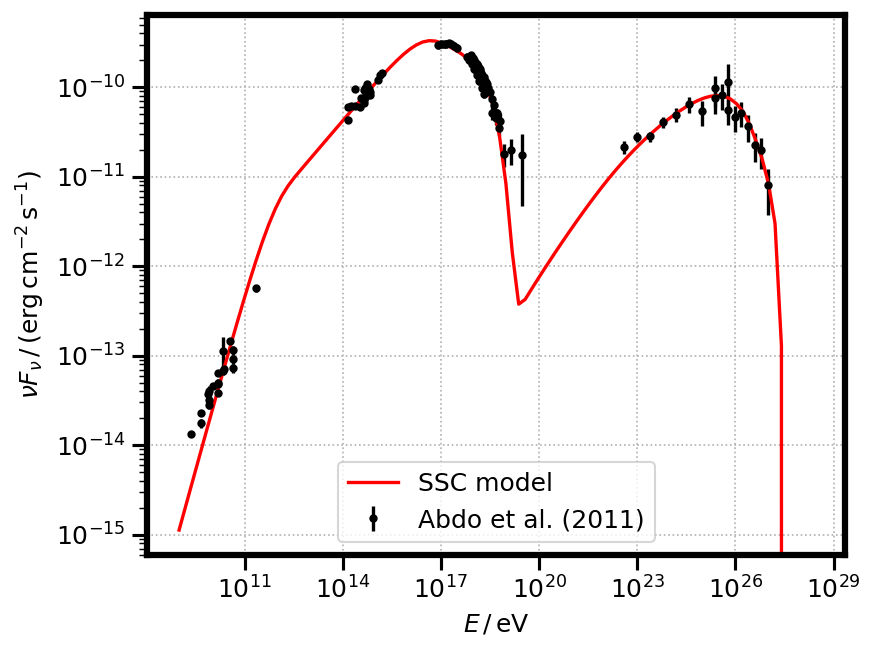

In [8]:
fitter = Fit(sed, ssc_model, stat=Chi2(), method=LevMar())

t.tic()
# perform the fit and time it!
results = fitter.fit()
print("Model fit succesful??", results.succeeded)
t.toc()
print('=================================================')
print("Model fit Parameters")
print(results.format())


plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['axes.linewidth'] = 3
    
fig, ax = plt.subplots()
    
ax.errorbar(freq/4.13E-15, flux, yerr = flux_err, marker = ".", ls = "", color = "k", label = "Abdo et al. (2011)")
ax.loglog(E/4.13E-15, ssc_model(E), ls = "-", color = "red", label = "SSC model")

plt.ylabel(sed_y_label)
plt.xlabel(r"$E\,/\,{\rm eV}$")
plt.legend()
